In [1]:
# !pip install implicit

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [3]:
data = pd.read_csv('retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [5]:
data_train.shape[0], data_test.shape[0]

(2278490, 118314)

In [6]:
users, items, interactions = data.user_id.nunique(), data.item_id.nunique(), data.shape[0]

print('# users: ', users)
print('# items: ', items)
print('# interactions: ', interactions)

# users:  2499
# items:  89051
# interactions:  2396804


In [7]:
popularity = data.groupby('item_id')['sales_value'].sum().reset_index()
popularity.describe()

,item_id,sales_value
count,8.905100e+04,89051.000000
mean,5.115772e+06,83.458481
std,5.178973e+06,1628.715079
min,2.567100e+04,0.000000
25%,9.665830e+05,3.500000
50%,1.448516e+06,10.780000
75%,9.553042e+06,46.105000
max,1.802456e+07,467993.620000


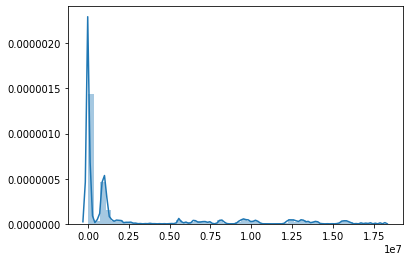

            item_id    sales_value
count  8.905100e+04   89051.000000
mean   5.115772e+06      83.458481
std    5.178973e+06    1628.715079
min    2.567100e+04       0.000000
25%    9.665830e+05       3.500000
50%    1.448516e+06      10.780000
75%    9.553042e+06      46.105000
max    1.802456e+07  467993.620000


In [8]:
import seaborn
from matplotlib.pyplot import show  # чтобы смотреть картинки без сохранения


def desc(df):
    seaborn.distplot(popularity)  # подготовим гистограмму и кривую распределения
    show()  # покажем картинку
    print(df.describe())
    
desc(popularity)

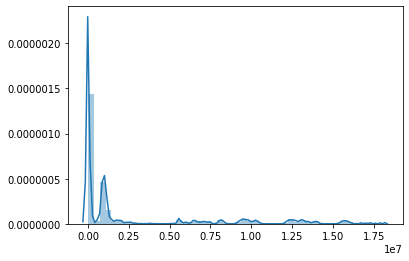

            item_id       user_id
count  8.905100e+04  89051.000000
mean   5.115772e+06     14.759767
std    5.178973e+06     45.904111
min    2.567100e+04      1.000000
25%    9.665830e+05      1.000000
50%    1.448516e+06      2.000000
75%    9.553042e+06     10.000000
max    1.802456e+07   2039.000000


In [9]:
popularity = data.groupby('item_id')['user_id'].nunique().reset_index()
desc(popularity)

In [10]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [11]:
test_users = result.shape[0]
new_test_users = len(set(data_test['user_id']) - set(data_train['user_id']))

print('В тестовом дата сете {} юзеров'.format(test_users))
print('В тестовом дата сете {} новых юзеров'.format(new_test_users))

В тестовом дата сете 2042 юзеров
В тестовом дата сете 0 новых юзеров


### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

In [12]:
def weighted_random_recommendation(items_weights, n=5):
    
    
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    
    items = np.array(items_weights['item_id']) 
    weights = items_weights['weight'].tolist()
    recs = np.random.choice(items, size=n, replace=False, p=weights)
    
    # Подсказка: необходимо модифицировать функцию random_recommendation()
    # your_code
    
    return recs.tolist()

In [13]:
%%time

# Товары с рейтингом популярности.
items_weights = data.groupby('item_id')['sales_value'].sum().reset_index()

# Логарифм от объема продаж. Для товаров с суммой покупки меньше 1$ считаем вероятность купить этот товар равной нулю.
items_weights['log_sales_value'] = items_weights.sales_value.apply(lambda x: 0 if x < 1 else np.log(x))

# Сумма log_sales_value по всем товарам.
log_sales_value_sum = items_weights.log_sales_value.sum()

# Расчет веса товара по популярности.
items_weights['weight'] = items_weights.log_sales_value.apply(lambda x: x / log_sales_value_sum)

items_weights.head()


CPU times: user 219 ms, sys: 37.6 ms, total: 257 ms
Wall time: 257 ms


,item_id,sales_value,log_sales_value,weight
0,25671,20.94,3.041661,0.000013
1,26081,0.99,0.000000,0.000000
2,26093,1.59,0.463734,0.000002
3,26190,1.54,0.431782,0.000002
4,26355,1.98,0.683097,0.000003


In [14]:
%%time

items_weights = data_train.groupby('item_id')['sales_value'].sum().reset_index()
items_weights = items_weights[items_weights['sales_value']>1]
items_weights['weight']= np.log(items_weights['sales_value'] + 0.001)
items_weights['weight'] = items_weights['weight'] / items_weights['weight'].sum()
items_weights.drop('sales_value', axis=1, inplace=True)

result['weighted_random_recommendation'] = result['user_id'].apply\
                                    (lambda x: weighted_random_recommendation(items_weights, n=5))
result.head(5)

CPU times: user 12.1 s, sys: 153 ms, total: 12.2 s
Wall time: 12.9 s


,user_id,actual,weighted_random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1060609, 893852, 9446753, 915774, 1099802]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[892378, 9677431, 841469, 12263464, 1010652]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[8359136, 1075313, 12425418, 1071678, 1130585]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1098487, 846380, 1052190, 13513398, 5567915]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[957999, 1130850, 904997, 15927361, 1388950]"


### Задание 2. Расчет метрик
Рассчитайте Precision@5 для каждого алгоритма с помощью функции из вебинара 1. Какой алгоритм показывает лучшее качество?

In [15]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision


In [16]:
for col in result.iloc[:,2:]:
    print("Precision@5 для алгоритма", col, ": ","{0:}".format(result.apply
          (lambda row: precision_at_k(row[col], row['actual'], k=5), axis=1).mean()))

Precision@5 для алгоритма weighted_random_recommendation :  0.001077375122428991


In [17]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

popularity.head()

,item_id,n_sold
0,25671,6
1,26081,1
2,26093,1
3,26190,1
4,26355,2


In [18]:
top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [19]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

/Users/daniilstv/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
user_item_matrix.shape

(2499, 5001)

In [21]:
user_item_matrix.sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1]) * 100

5.33770796861036

In [22]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [23]:
%%time

model = ItemItemRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=True, 
                        filter_items=None, 
                        recalculate_user=True)


CPU times: user 1.99 s, sys: 37.3 ms, total: 2.03 s
Wall time: 2.26 s


In [24]:
print(recs)
[id_to_itemid[rec[0]] for rec in recs]

[(2148, 57995.0), (2307, 11956.0), (2757, 1507.0), (1178, 773.0), (340, 418.0)]


[981760, 995242, 1029743, 904360, 844179]

In [25]:
%%time

result['itemitem'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=True, 
                                    filter_items=None, 
                                    recalculate_user=True)])

result.head(3)

CPU times: user 89.1 ms, sys: 4.39 ms, total: 93.5 ms
Wall time: 108 ms


,user_id,actual,weighted_random_recommendation,itemitem
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1060609, 893852, 9446753, 915774, 1099802]","[981760, 1127831, 1098066, 826249, 878996]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[892378, 9677431, 841469, 12263464, 1010652]","[981760, 995242, 1029743, 840361, 961554]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[8359136, 1075313, 12425418, 1071678, 1130585]","[1098066, 826249, 1106523, 923746, 1058997]"


In [26]:
%%time

model = CosineRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(), 
          show_progress=True)

recs = model.recommend(userid=userid_to_id[1], 
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, 
                        filter_already_liked_items=True, 
                        filter_items=None, 
                        recalculate_user=False)

[id_to_itemid[rec[0]] for rec in recs]


CPU times: user 1.83 s, sys: 43.6 ms, total: 1.87 s
Wall time: 1.9 s


[981760, 1127831, 1098066, 878996, 826249]

In [27]:
%%time

result['cosine'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=True, 
                                    filter_items=None, 
                                    recalculate_user=True)])
result.head(3)

CPU times: user 90.6 ms, sys: 3.27 ms, total: 93.8 ms
Wall time: 95.5 ms


,user_id,actual,weighted_random_recommendation,itemitem,cosine
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1060609, 893852, 9446753, 915774, 1099802]","[981760, 1127831, 1098066, 826249, 878996]","[981760, 1127831, 1098066, 878996, 826249]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[892378, 9677431, 841469, 12263464, 1010652]","[981760, 995242, 1029743, 840361, 961554]","[981760, 1004906, 961554, 1096036, 1080414]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[8359136, 1075313, 12425418, 1071678, 1130585]","[1098066, 826249, 1106523, 923746, 1058997]","[1098066, 826249, 860776, 854852, 1068719]"


In [28]:
%%time

model = TFIDFRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(), 
          show_progress=True)

recs = model.recommend(userid=userid_to_id[1], 
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, 
                        filter_already_liked_items=True, 
                        filter_items=None, 
                        recalculate_user=False)

[id_to_itemid[rec[0]] for rec in recs]


CPU times: user 1.99 s, sys: 35.2 ms, total: 2.03 s
Wall time: 2.13 s


[981760, 1127831, 1098066, 826249, 878996]

In [29]:
%%time

result['tfidf'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=True, 
                                    filter_items=None, 
                                    recalculate_user=False)])

result.head(3)

CPU times: user 90.4 ms, sys: 2.57 ms, total: 93 ms
Wall time: 98.2 ms


,user_id,actual,weighted_random_recommendation,itemitem,cosine,tfidf
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1060609, 893852, 9446753, 915774, 1099802]","[981760, 1127831, 1098066, 826249, 878996]","[981760, 1127831, 1098066, 878996, 826249]","[981760, 1127831, 1098066, 826249, 878996]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[892378, 9677431, 841469, 12263464, 1010652]","[981760, 995242, 1029743, 840361, 961554]","[981760, 1004906, 961554, 1096036, 1080414]","[981760, 1004906, 859075, 1096036, 961554]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[8359136, 1075313, 12425418, 1071678, 1130585]","[1098066, 826249, 1106523, 923746, 1058997]","[1098066, 826249, 860776, 854852, 1068719]","[1098066, 826249, 860776, 1068719, 916122]"


In [30]:
%%time

model = ItemItemRecommender(K=1, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(), 
          show_progress=True)

recs = model.recommend(userid=userid_to_id[1], 
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, 
                        filter_already_liked_items=True, 
                        filter_items=None, 
                        recalculate_user=False)

[id_to_itemid[rec[0]] for rec in recs]




CPU times: user 1.72 s, sys: 26.3 ms, total: 1.75 s
Wall time: 1.8 s


[10455984, 12172240, 12810393, 15926844, 12324948]

In [31]:
%%time

result['own_purchases'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[999999], 
                                    recalculate_user=False)])

result.head(3)

CPU times: user 70.9 ms, sys: 3.32 ms, total: 74.2 ms
Wall time: 75.9 ms


,user_id,actual,weighted_random_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1060609, 893852, 9446753, 915774, 1099802]","[981760, 1127831, 1098066, 826249, 878996]","[981760, 1127831, 1098066, 878996, 826249]","[981760, 1127831, 1098066, 826249, 878996]","[999999, 1082185, 1029743, 995785, 1004906]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[892378, 9677431, 841469, 12263464, 1010652]","[981760, 995242, 1029743, 840361, 961554]","[981760, 1004906, 961554, 1096036, 1080414]","[981760, 1004906, 859075, 1096036, 961554]","[999999, 1082185, 1098066, 6534178, 1127831]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[8359136, 1075313, 12425418, 1071678, 1130585]","[1098066, 826249, 1106523, 923746, 1058997]","[1098066, 826249, 860776, 854852, 1068719]","[1098066, 826249, 860776, 1068719, 916122]","[999999, 1082185, 1029743, 6534178, 1127831]"


In [32]:
# result = pd.read_csv('predictions_basic.csv')
# result.head(5)

In [33]:
result2 = pd.read_csv('predictions_basic.csv')
result2.head(5)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,[ 821867 834484 856942 865456 889248 ...,"[8157117, 870291, 1846901, 891748, 1038560]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 1029743, 995785, 1004906, 1081177]"
1,3,[ 835476 851057 872021 878302 879948 ...,"[1000965, 10121560, 9878622, 13512901, 13039531]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]","[1082185, 1098066, 6534178, 1127831, 1068719]"
2,6,[ 920308 926804 946489 1006718 1017061 ...,"[5129567, 6555376, 9487756, 6533880, 1117945]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 878996, 961554]","[1082185, 1029743, 6534178, 1127831, 995785]"
3,7,[ 840386 889774 898068 909714 929067 ...,"[15740824, 9423981, 1052258, 13986798, 1003354]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 961554, 1098066]","[1082185, 981760, 1127831, 961554, 826249]","[1082185, 1029743, 1127831, 995785, 1044078]"
4,8,[ 835098 872137 910439 924610 992977 ...,"[1964658, 954745, 976261, 7025202, 1054432]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 1098066, 995242]","[1082185, 981760, 1098066, 826249, 1127831]","[1082185, 981760, 1098066, 826249, 1127831]","[1082185, 1029743, 1098066, 6534178, 1127831]"


In [34]:
result.iloc[0]

user_id                                                                           1
actual                            [821867, 834484, 856942, 865456, 889248, 90795...
weighted_random_recommendation          [1060609, 893852, 9446753, 915774, 1099802]
itemitem                                 [981760, 1127831, 1098066, 826249, 878996]
cosine                                   [981760, 1127831, 1098066, 878996, 826249]
tfidf                                    [981760, 1127831, 1098066, 826249, 878996]
own_purchases                           [999999, 1082185, 1029743, 995785, 1004906]
Name: 0, dtype: object

In [35]:
fact = result['actual']
fact[0]

array([  821867,   834484,   856942,   865456,   889248,   907957,
         914190,   943316,   951954,   954486,   958046,   962568,
         969231,   971585,   979707,   986947,   990656,   995242,
        1004906,  1005186,  1042083,  1050310,  1060819,  1062002,
        1064441,  1069733,  1074612,  1082185,  1131115,  1132771,
        6534544, 13876341, 15971874, 17178953,   883616,   917704,
         931860,   961554,  1002032,  1031190,  8090541,  8293439,
        9297615,  9527329, 15926712,  1049998,   861272,   869465,
         877373,   908213,   933913,   940947,   945809,   959316,
         978974,  1031697,  1041796,  1048918,  1081189,  1101422,
        1115576,  1122428,  1132231,  1132814,  5577022,  8091601,
        9296986,  9677939, 10356149, 13417048, 15741823, 15830875])

In [36]:
result.columns[2:]

Index(['weighted_random_recommendation', 'itemitem', 'cosine', 'tfidf',
       'own_purchases'],
      dtype='object')

In [39]:
result2.columns[2:]

Index(['random_recommendation', 'popular_recommendation', 'itemitem', 'cosine',
       'tfidf', 'own_purchases'],
      dtype='object')

In [41]:
columns = result.columns.drop(['user_id', 'actual'])
actual = result.actual
users_count = result.shape[0]

In [42]:
for column in columns:
    sum_p = 0
    precisions_by_user = [precision_at_k(actual[i], result[column][i], k=5) for i in range(users_count)]
    precisions_mean = np.mean(precisions_by_user)

    print('{:35} {:.4f} %'.format(column, precisions_mean * 100))

weighted_random_recommendation      0.0000 %
itemitem                            0.7476 %
cosine                              0.6995 %
tfidf                               0.7484 %
own_purchases                       2.7016 %


### Задание 3*. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая их на топ- {2000, 5000, 10000} товаров. Постройте график зависимости precision@5 от топ-*
- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$. Постройте график зависимости precision@5 от $K$ 

In [ ]:
# your_code